# Step 01

Import Required Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.utils import class_weight, resample
import xgboost as xgb
from tabulate import tabulate
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score



Define Focal Loss Function (used for CNN training to handle class imbalance)

In [8]:

def focal_loss(gamma=1.0, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
        bce = -y_true * tf.math.log(y_pred) - (1.0 - y_true) * tf.math.log(1.0 - y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        focal_factor = tf.pow(1.0 - p_t, gamma)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        return tf.reduce_mean(alpha_t * focal_factor * bce)
    return focal_loss_fixed


Data Augmentation Function: Add Gaussian noise and random shift to light curves

In [9]:

def augment_data(X, y, sigma=0.04, max_shift=200):
    X_aug = X.copy()
    noise = np.random.normal(0, sigma, X.shape)
    X_aug += noise
    shifts = np.random.randint(-max_shift, max_shift, size=X.shape[0])
    for i in range(X.shape[0]):
        X_aug[i] = np.roll(X_aug[i], shifts[i], axis=0)
    return X_aug, y


Bootstrap Evaluation Function for confidence intervals

In [10]:
def bootstrap_metrics(y_true, y_pred_proba, n_bootstraps=1000):
    aucs, recalls, precisions, f1s = [], [], [], []
    n_samples = len(y_true)
    for _ in range(n_bootstraps):
        idx = resample(np.arange(n_samples), stratify=y_true)
        y_true_boot = y_true[idx]
        y_pred_proba_boot = y_pred_proba[idx]
        y_pred_boot = (y_pred_proba_boot > 0.3).astype(int)
        aucs.append(roc_auc_score(y_true_boot, y_pred_proba_boot))
        report = classification_report(y_true_boot, y_pred_boot, output_dict=True, zero_division=0)['1']
        recalls.append(report['recall'])
        precisions.append(report['precision'])
        f1s.append(report['f1-score'])
    auc_ci = np.percentile(aucs, [2.5, 97.5])
    recall_ci = np.percentile(recalls, [2.5, 97.5])
    precision_ci = np.percentile(precisions, [2.5, 97.5])
    f1_ci = np.percentile(f1s, [2.5, 97.5])
    return (
        np.mean(aucs), auc_ci,
        np.mean(recalls), recall_ci,
        np.mean(precisions), precision_ci,
        np.mean(f1s), f1_ci
    )


Grad-CAM Implementation for 1D-CNN

In [11]:
def apply_grad_cam(model, input_data, class_index=None, layer_name='conv1d_2'):
    input_data = np.expand_dims(input_data, axis=0)
    inputs = model.input
    conv_layer = model.get_layer(layer_name)
    grad_model = Model(inputs=inputs, outputs=[conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        if class_index is None:
            class_index = 1 if predictions[0] >= 0.3 else 0
        loss = predictions if class_index == 1 else 1.0 - predictions

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=0)
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    heatmap_resized = np.interp(np.arange(3197), np.linspace(0, 3197, len(heatmap)), heatmap)
    return heatmap_resized, class_index


# Step 02: Load and Explore the Datasets (with plots)

Load Kepler datasets: summary info and raw light curves

In [13]:
try:
    summary_data = pd.read_csv("/kaggle/input/kepler-exoplanet-search-results/cumulative.csv")
    raw_train_data = pd.read_csv("/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv")
    raw_test_data = pd.read_csv("/kaggle/input/kepler-labelled-time-series-data/exoTest.csv")

    print("Datasets Loaded Successfully!")
    print(f"Summary Dataset Shape: {summary_data.shape}")
    print(f"Train Light Curves Shape: {raw_train_data.shape}")
    print(f"Test Light Curves Shape: {raw_test_data.shape}")

except FileNotFoundError:
    print("ERROR: Dataset files not found.")


Datasets Loaded Successfully!
Summary Dataset Shape: (9564, 50)
Train Light Curves Shape: (5087, 3198)
Test Light Curves Shape: (570, 3198)


Display first 5 rows of each dataset

In [14]:
print("\n First 5 Rows from Summary Data:")
display(summary_data.head())

print("\n First 5 Rows from Raw Training Data:")
display(raw_train_data.head())



 First 5 Rows from Summary Data:


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509



 First 5 Rows from Raw Training Data:


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Choose 3 random samples from the training data

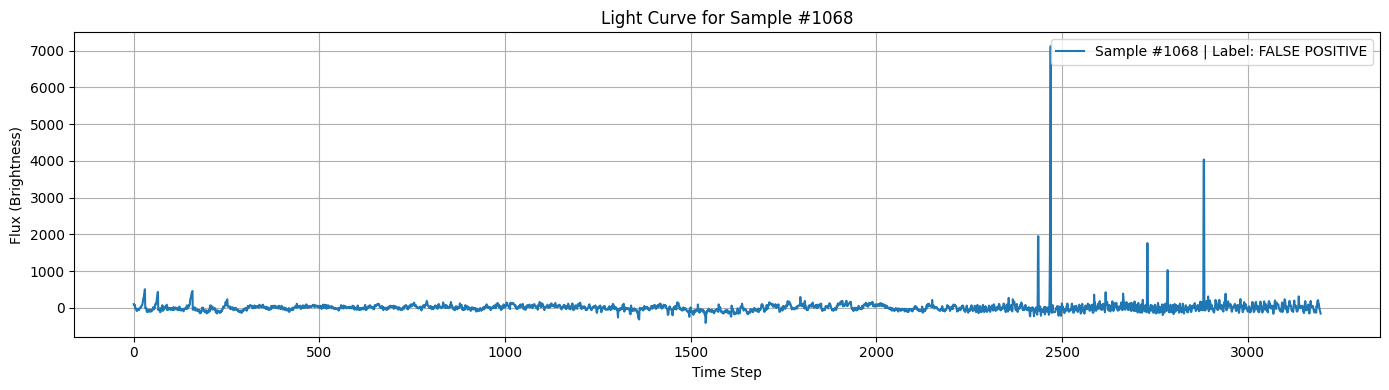

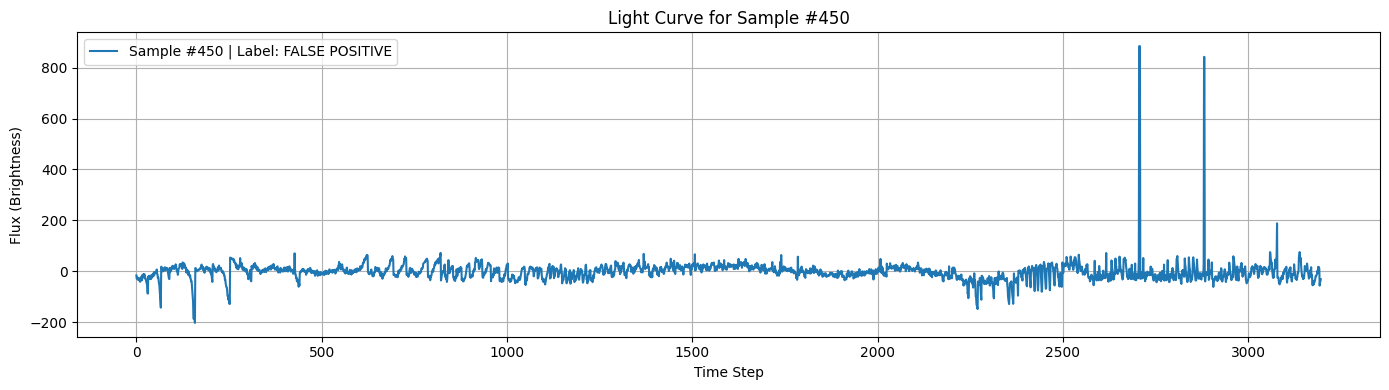

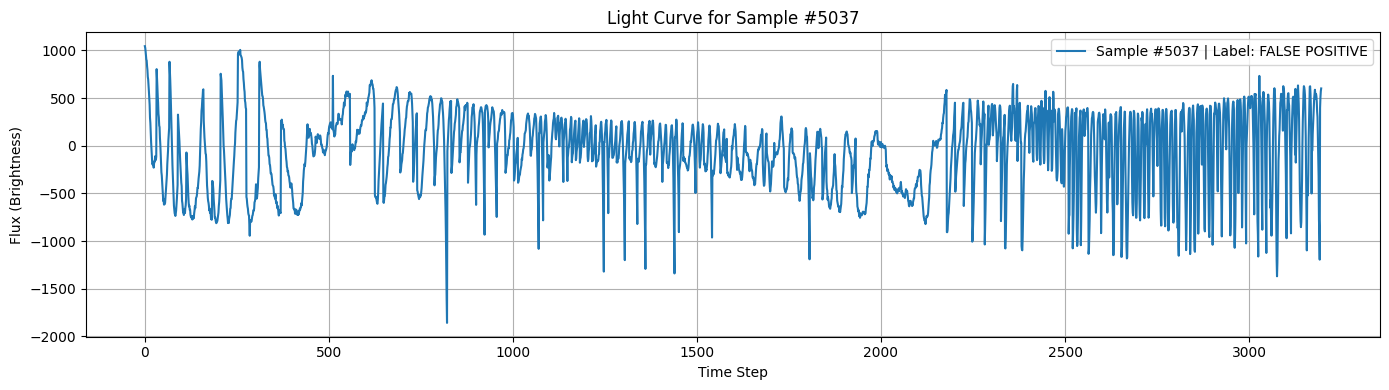

In [15]:
num_samples = 3
sample_indices = np.random.choice(raw_train_data.shape[0], num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    label = raw_train_data.iloc[idx]['LABEL']
    flux_values = raw_train_data.iloc[idx, 1:].values  # Skip LABEL column
    plt.figure(figsize=(14, 4))
    plt.plot(flux_values, label=f"Sample #{idx} | Label: {'CONFIRMED' if label == 2 else 'FALSE POSITIVE'}")
    plt.xlabel("Time Step")
    plt.ylabel("Flux (Brightness)")
    plt.title(f"Light Curve for Sample #{idx}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Bar Chart: Disposition Counts (CONFIRMED, FALSE POSITIVE, CANDIDATE)

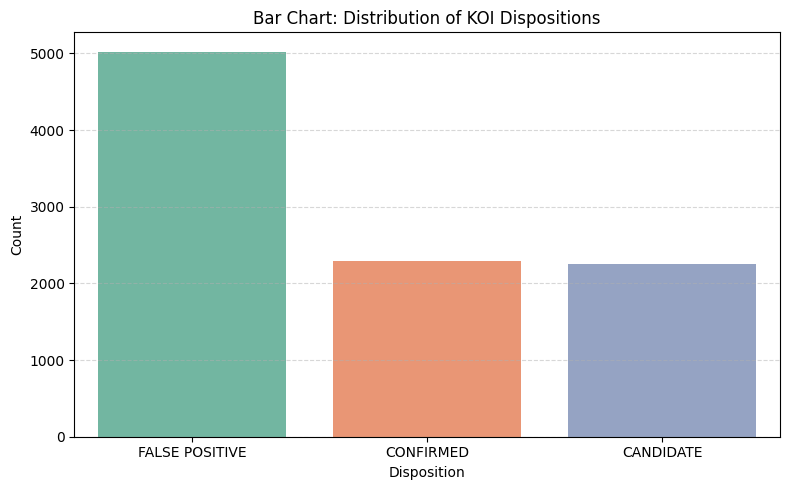

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(data=summary_data, x='koi_disposition', order=summary_data['koi_disposition'].value_counts().index, palette='Set2')
plt.title("Bar Chart: Distribution of KOI Dispositions")
plt.xlabel("Disposition")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Pie Chart: Distribution of Dispositions

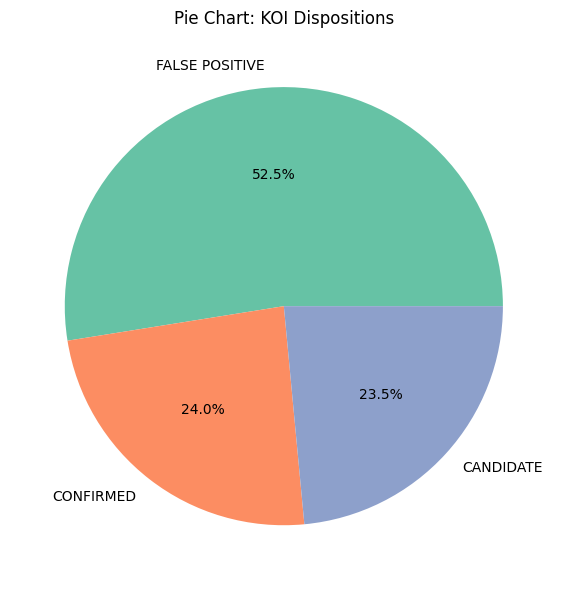

In [17]:
# Pie chart of koi_disposition
disposition_counts = summary_data['koi_disposition'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(disposition_counts, labels=disposition_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("Pie Chart: KOI Dispositions")
plt.tight_layout()
plt.show()


Histogram: Planetary Radius (koi_prad)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


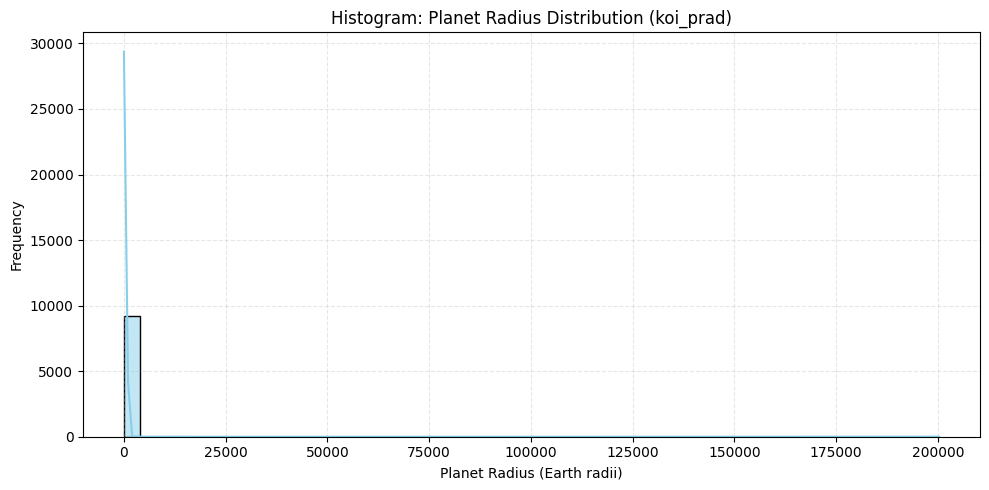

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(summary_data['koi_prad'].dropna(), bins=50, kde=True, color='skyblue')
plt.title("Histogram: Planet Radius Distribution (koi_prad)")
plt.xlabel("Planet Radius (Earth radii)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Summary_data – Density for Numeric Features

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

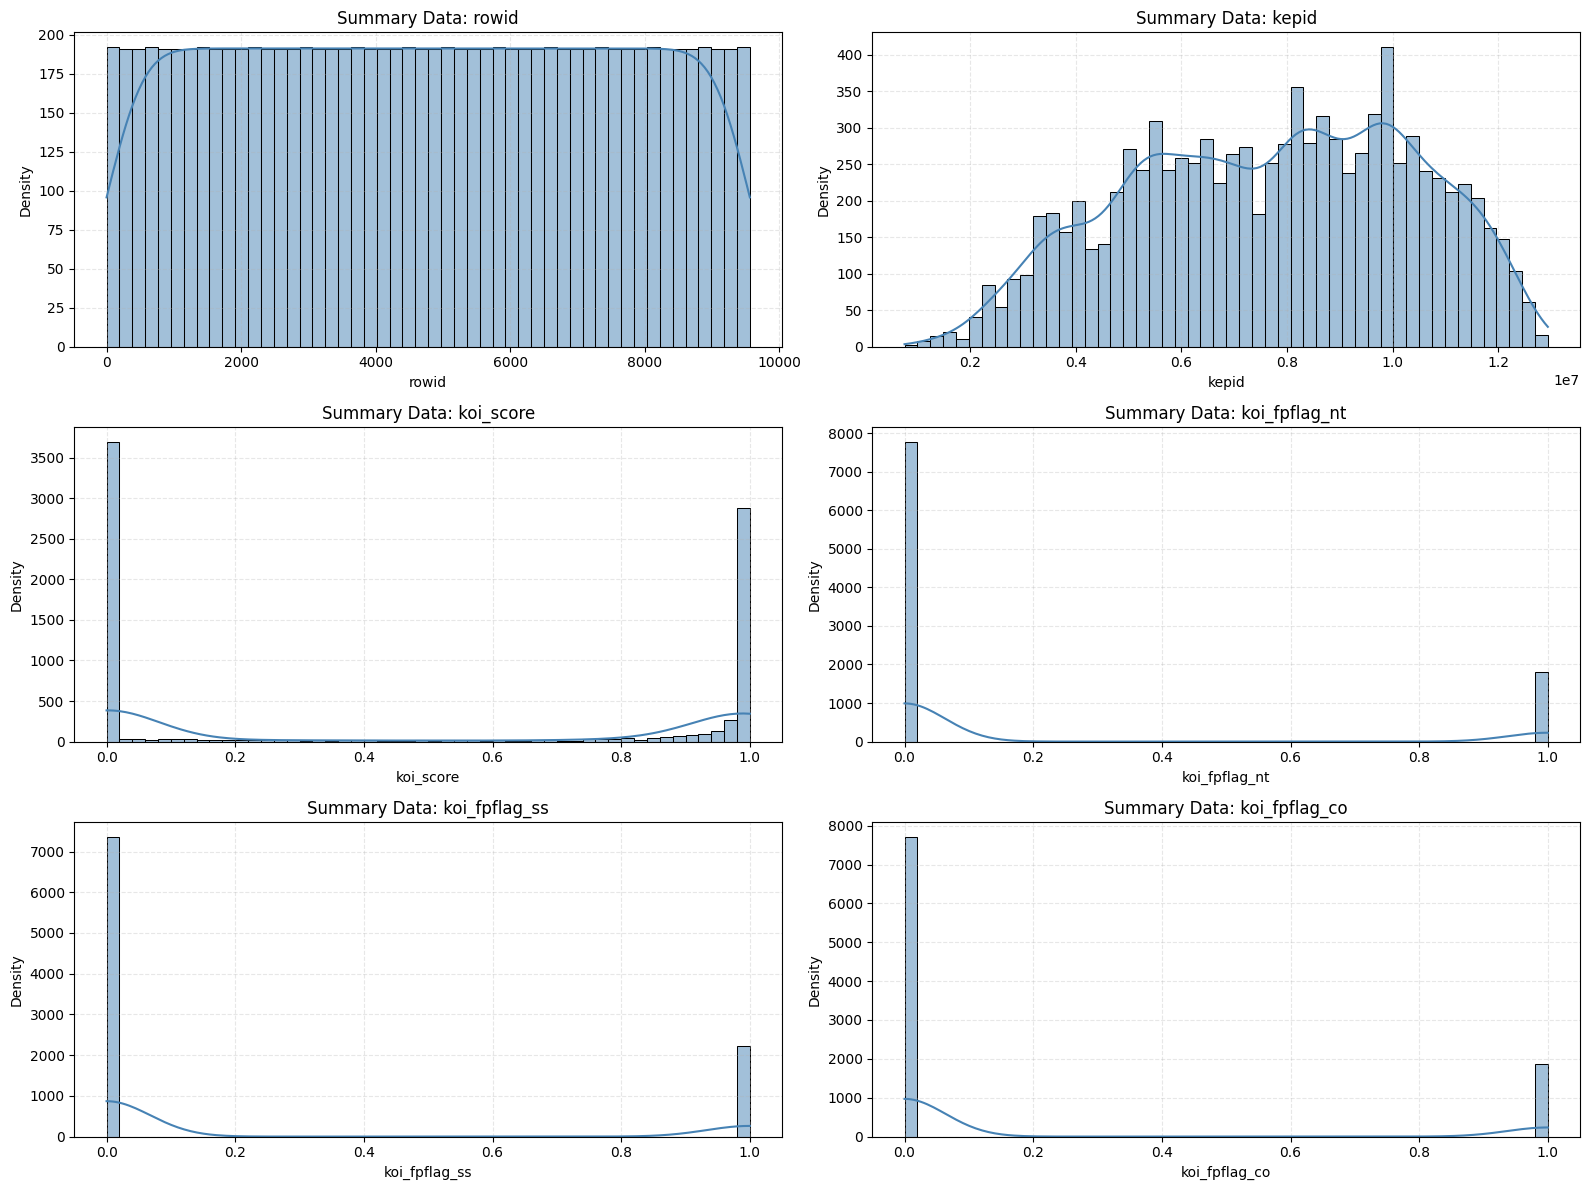

In [19]:
# Select only numeric columns from summary_data
numeric_cols_summary = summary_data.select_dtypes(include=[np.number]).columns

# Plot density plots for top 6 most relevant numeric features
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols_summary[:6], 1):
    plt.subplot(3, 2, i)
    sns.histplot(summary_data[col].dropna(), kde=True, color='steelblue', bins=50)
    plt.title(f"Summary Data: {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


raw_train_data – Flux Density by Class (LABEL)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


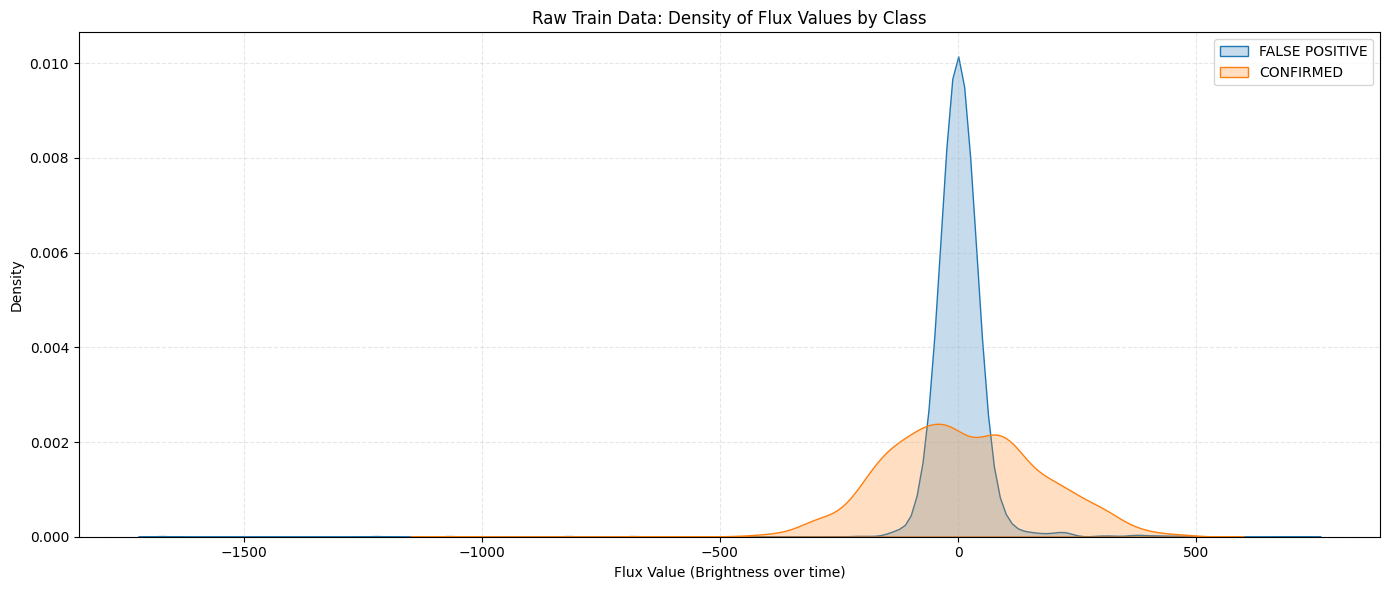

In [20]:
# Plot average flux distributions by class in raw_train_data
plt.figure(figsize=(14, 6))

for label in [1, 2]:
    label_name = "CONFIRMED" if label == 2 else "FALSE POSITIVE"
    sample = raw_train_data[raw_train_data['LABEL'] == label].iloc[0, 1:]  # skip LABEL column
    sns.kdeplot(sample, label=label_name, fill=True)

plt.title("Raw Train Data: Density of Flux Values by Class")
plt.xlabel("Flux Value (Brightness over time)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


raw_test_data – Flux Density by Class (LABEL)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


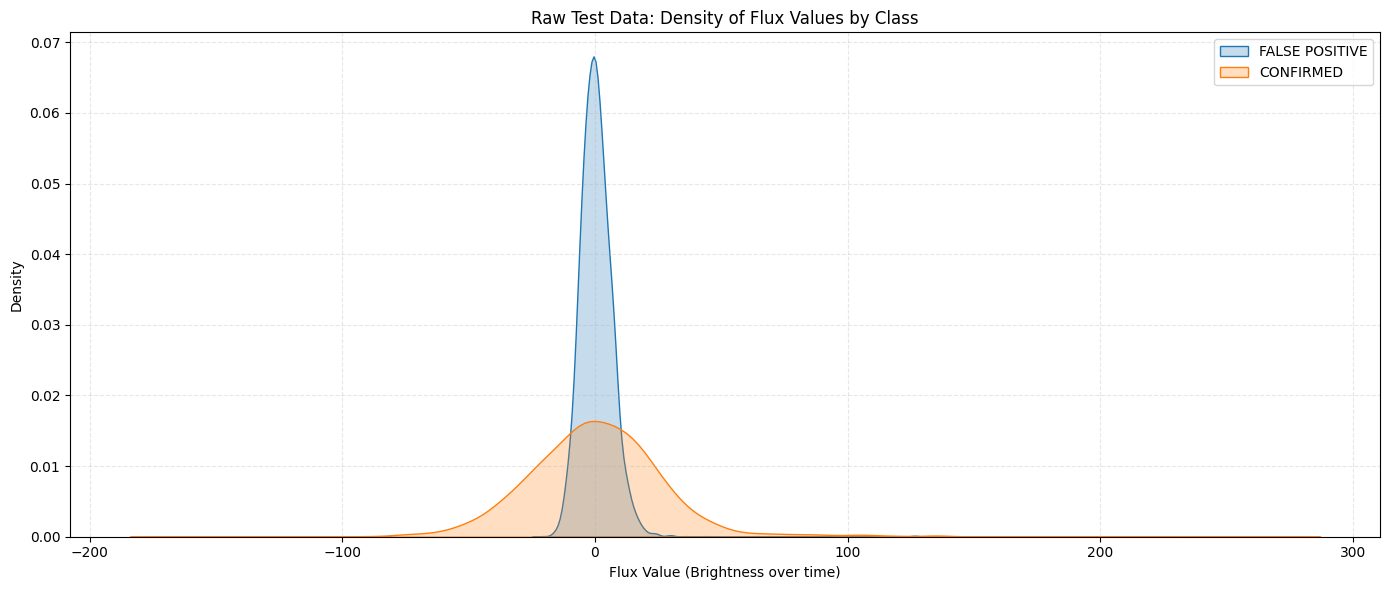

In [21]:
# Plot average flux distributions by class in raw_test_data
plt.figure(figsize=(14, 6))

for label in [1, 2]:
    label_name = "CONFIRMED" if label == 2 else "FALSE POSITIVE"
    sample = raw_test_data[raw_test_data['LABEL'] == label].iloc[0, 1:]
    sns.kdeplot(sample, label=label_name, fill=True)

plt.title("Raw Test Data: Density of Flux Values by Class")
plt.xlabel("Flux Value (Brightness over time)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Step 3: Data Preprocessing

Select relevant features and clean missing data

In [23]:
# Select only CONFIRMED and FALSE POSITIVE rows
baseline_df = summary_data[summary_data['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()

# Define features used for XGBoost
features_to_use = [
    'koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
    'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff',
    'koi_slogg', 'koi_srad'
]

# Drop missing values
baseline_df.dropna(subset=features_to_use, inplace=True)

# Encode labels
label_encoder = LabelEncoder()
baseline_df['label_encoded'] = label_encoder.fit_transform(baseline_df['koi_disposition'])


 Plot histograms for each feature

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

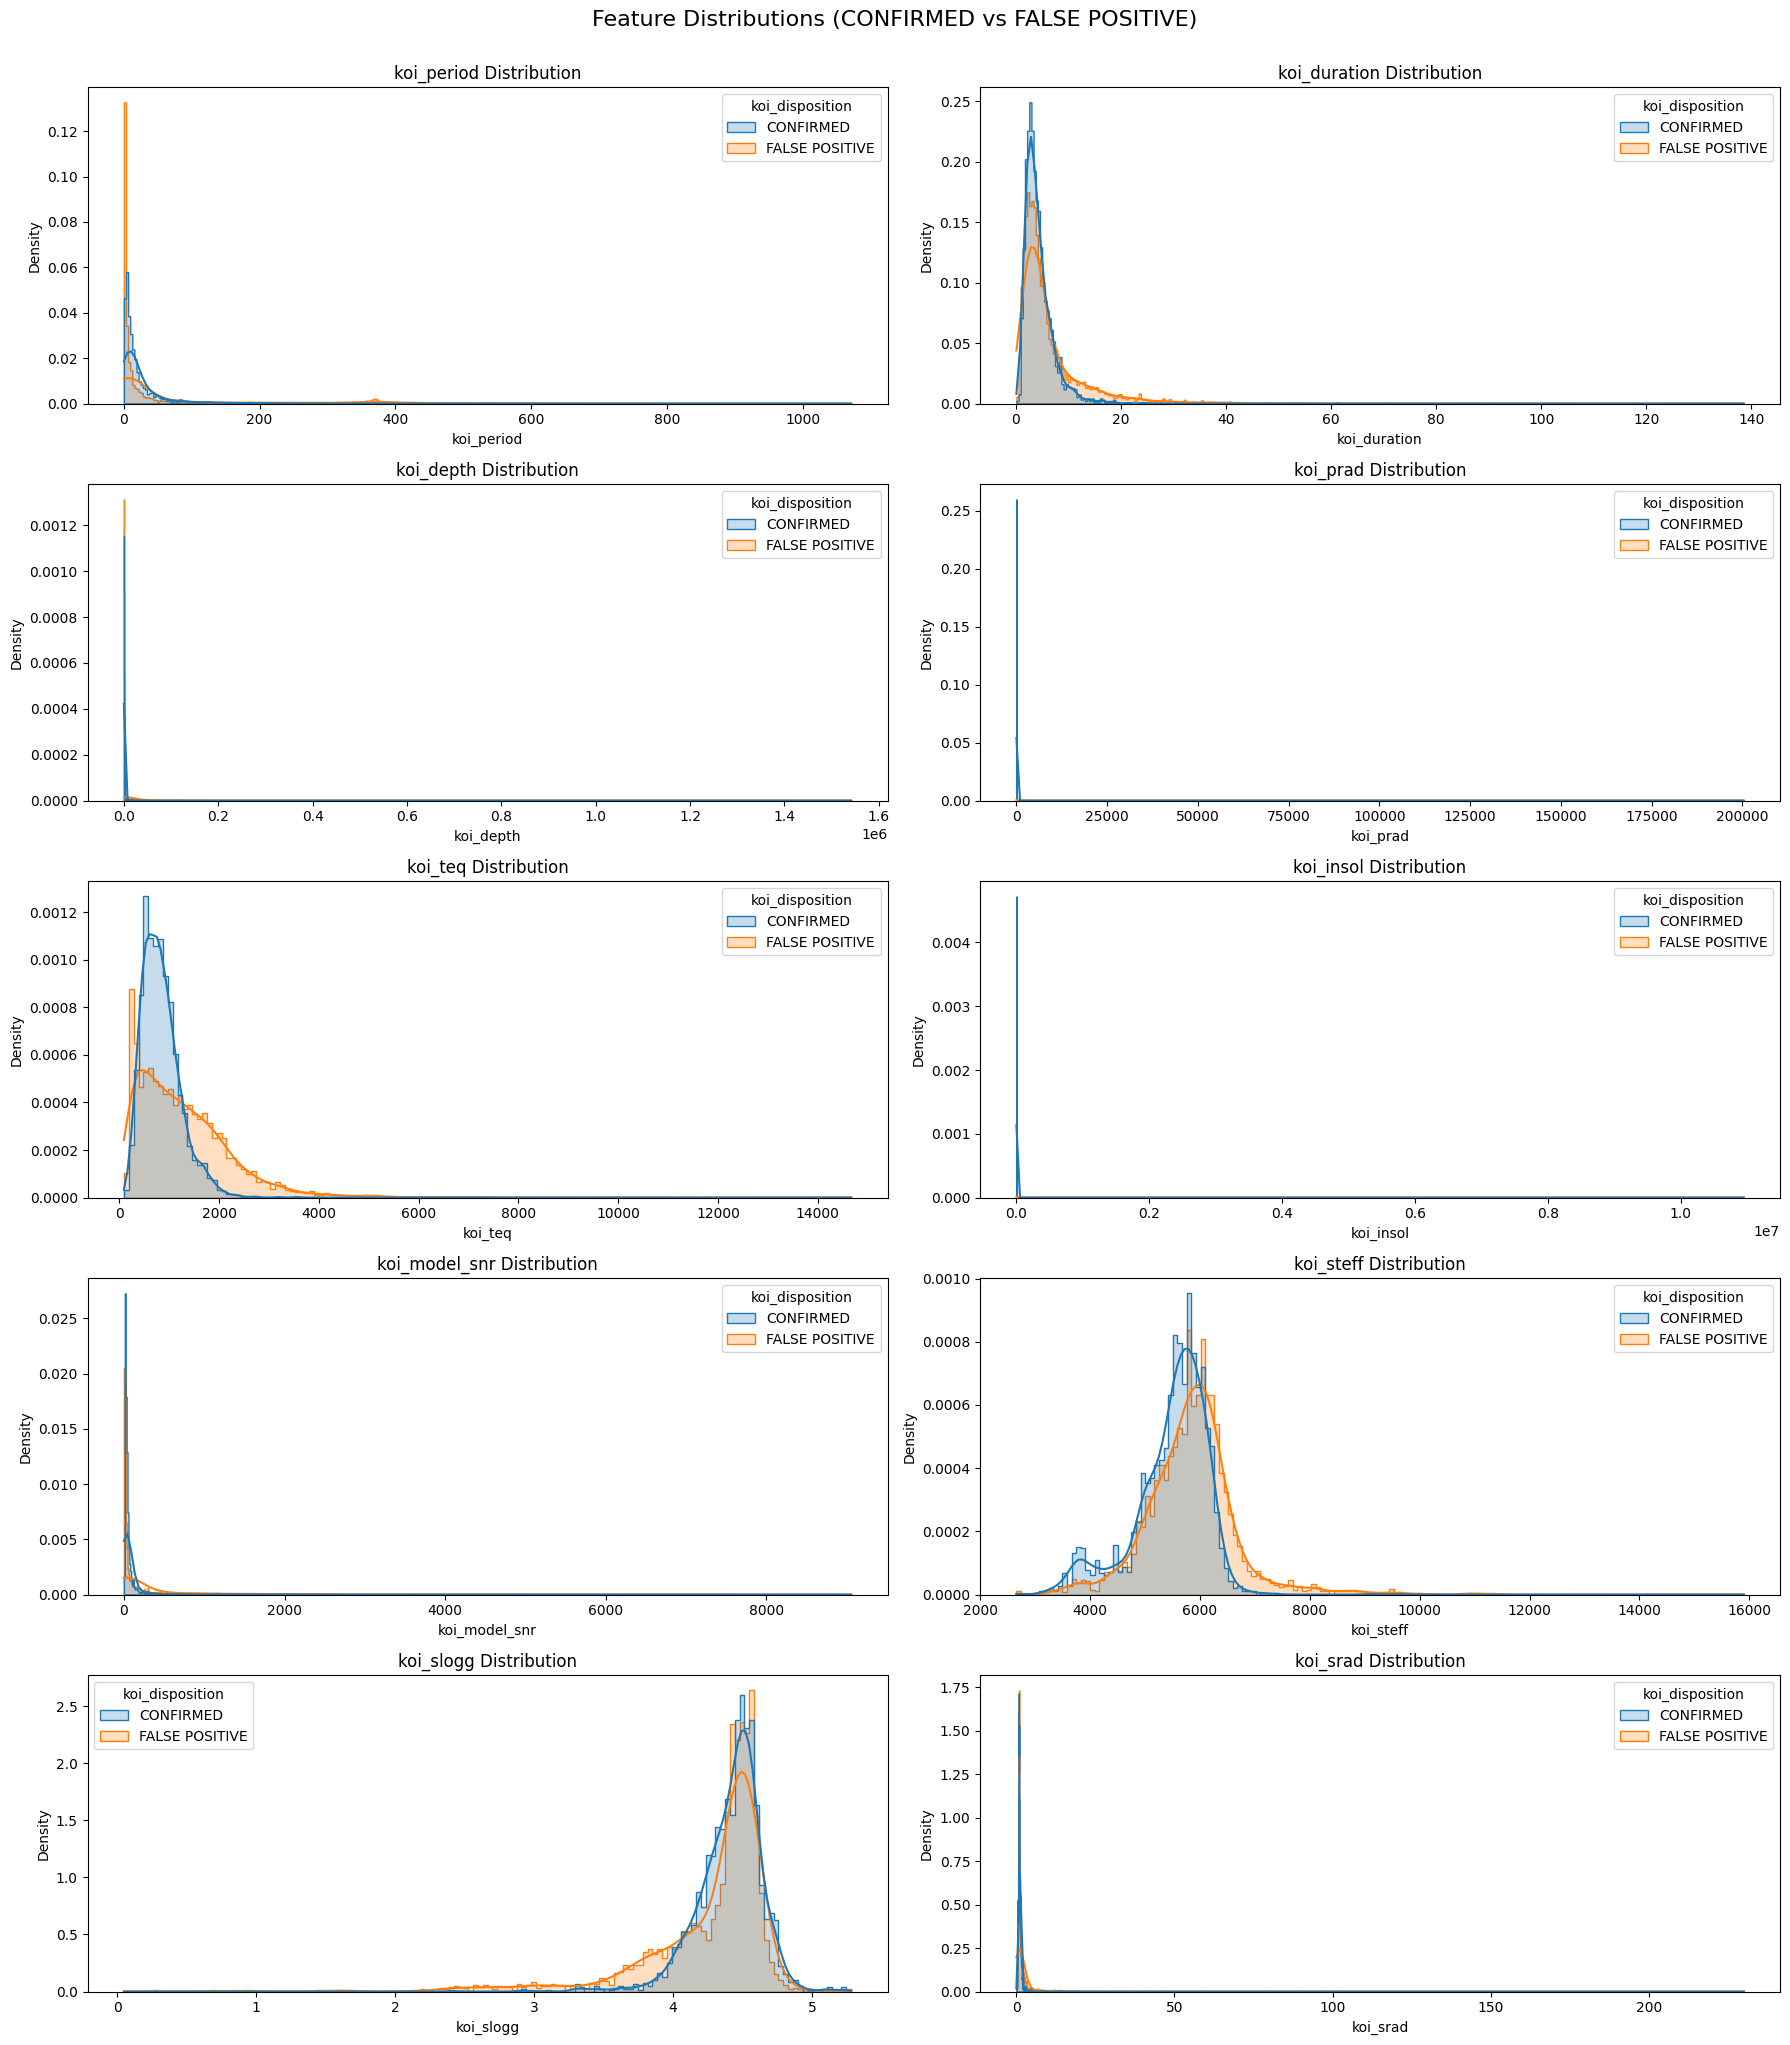

In [24]:
# Histogram with KDE for each feature
import matplotlib.gridspec as gridspec

plt.figure(figsize=(18, 20))
gs = gridspec.GridSpec(5, 2)

for i, feature in enumerate(features_to_use):
    ax = plt.subplot(gs[i])
    sns.histplot(data=baseline_df, x=feature, hue='koi_disposition', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"{feature} Distribution")
    plt.tight_layout()

plt.suptitle("Feature Distributions (CONFIRMED vs FALSE POSITIVE)", fontsize=16, y=1.02)
plt.show()


**Preprocessing for Raw Light Curve Data (exoTrain.csv + exoTest.csv) – CNN Model**

Merge and scale light curve data

In [25]:
# Merge raw train and test data
raw_data = pd.concat([raw_train_data, raw_test_data], ignore_index=True)

# Separate features and labels
X_raw = raw_data.drop(columns=['LABEL']).values
y_raw = raw_data['LABEL'].values - 1  # Convert to 0 (FP) and 1 (CONFIRMED)

# Standardize each light curve
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Reshape for CNN input
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)


 Visualize a few individual light curves

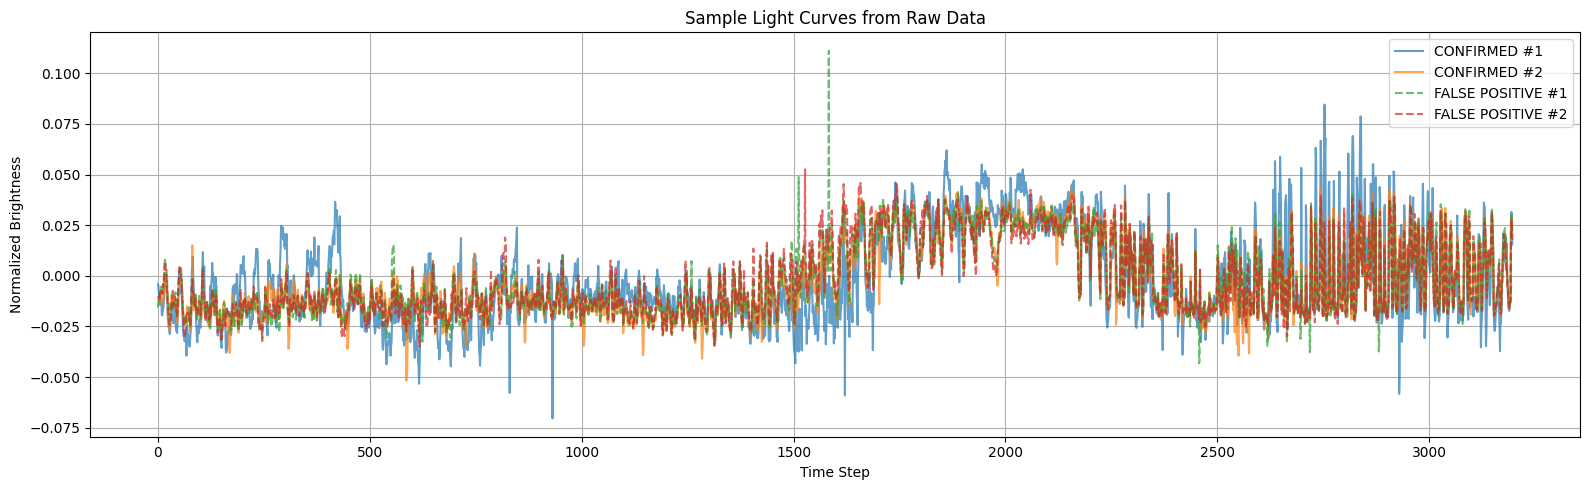

In [26]:
# Plot a few CONFIRMED and FALSE POSITIVE light curves
confirmed = X_cnn[y_raw == 1]
false_positive = X_cnn[y_raw == 0]

plt.figure(figsize=(16, 5))

# Plot 2 CONFIRMED light curves
for i in range(2):
    plt.plot(confirmed[i].flatten(), label=f'CONFIRMED #{i+1}', alpha=0.7)

# Plot 2 FALSE POSITIVE light curves
for i in range(2):
    plt.plot(false_positive[i].flatten(), label=f'FALSE POSITIVE #{i+1}', linestyle='--', alpha=0.7)

plt.title("Sample Light Curves from Raw Data")
plt.xlabel("Time Step")
plt.ylabel("Normalized Brightness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


class imbalance with a pie chart

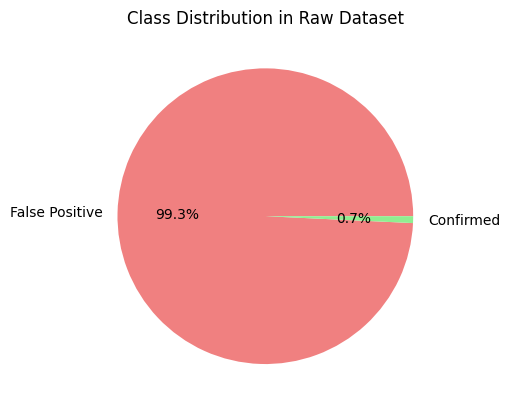

In [27]:
labels, counts = np.unique(y_raw, return_counts=True)
plt.pie(counts, labels=['False Positive', 'Confirmed'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title("Class Distribution in Raw Dataset")
plt.show()


# Step 4: Model Building & Training and Visualize

**This step involves training two separate models:**

* XGBoost on expert features from the summary dataset.
* 1D-CNN on raw light curve data.

**XGBoost on Summary Dataset**

Train-Test Split & Model Training

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Prepare input and output
X = baseline_df[features_to_use]
y = baseline_df['label_encoded']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Evaluate XGBoost

XGBoost Accuracy: 91.64%
AUC Score: 0.9710

Classification Report:
                precision    recall  f1-score   support

     CONFIRMED       0.87      0.88      0.87       688
FALSE POSITIVE       0.94      0.93      0.94      1417

      accuracy                           0.92      2105
     macro avg       0.90      0.91      0.91      2105
  weighted avg       0.92      0.92      0.92      2105



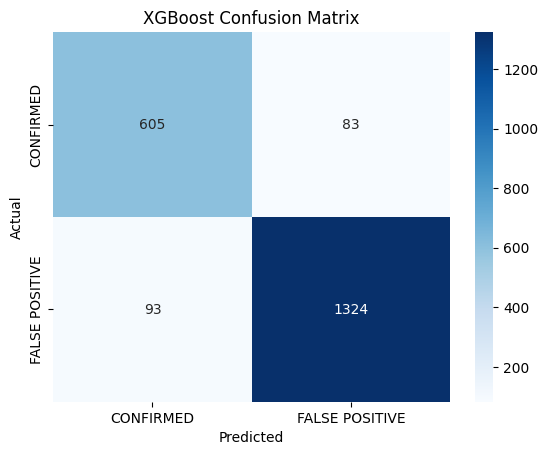

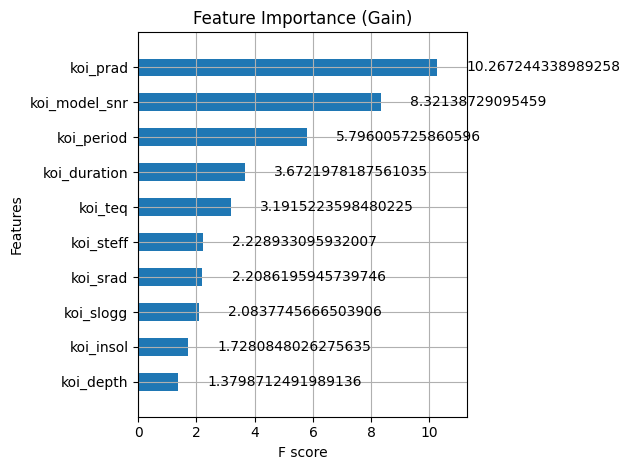

In [29]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Accuracy and AUC
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
xgb.plot_importance(xgb_model, importance_type='gain', height=0.5)
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()


**1D-CNN on Raw Light Curves**

5 fold Cross-Validation Setup

CNN Model Architecture & Training Loop


Fold 1

Model Summary:


Model: "exoplanet_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3197, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3191, 16)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 3191, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 797, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 791, 32)        │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 791, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 197, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 191, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 191, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,817 (89.13 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8432 - loss: 1.1248 - val_accuracy: 0.9920 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8850 - loss: 0.5159 - val_accuracy: 0.9912 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8977 - loss: 0.2780 - val_accuracy: 0.9912 - val_loss: 0.1703 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8939 - loss: 0.1827 - val_accuracy: 0.9920 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8934 - loss: 0.1381 - val_accuracy: 0.9912 - val_loss: 0.0979 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8989 - loss: 0.1102 - val_accuracy: 0.9903 - val_loss: 0.0749 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8953 - loss: 0.0998 -

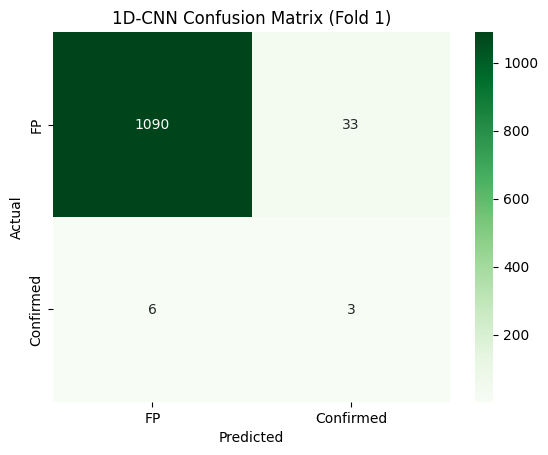

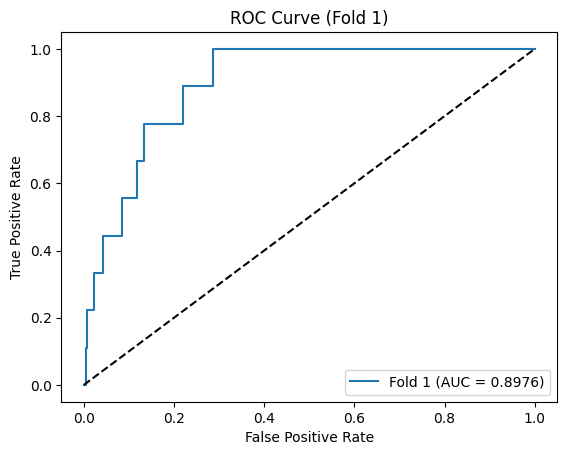


Fold 2
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.8125 - loss: 1.1512 - val_accuracy: 0.9912 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8908 - loss: 0.5051 - val_accuracy: 0.9912 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8899 - loss: 0.2616 - val_accuracy: 0.9903 - val_loss: 0.1499 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8824 - loss: 0.1671 - val_accuracy: 0.9920 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.8885 - loss: 0.1259 - val_accuracy: 0.9920 - val_loss: 0.0700 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8934 - loss: 0.1021 - val_accuracy: 0.9894 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8898 - loss

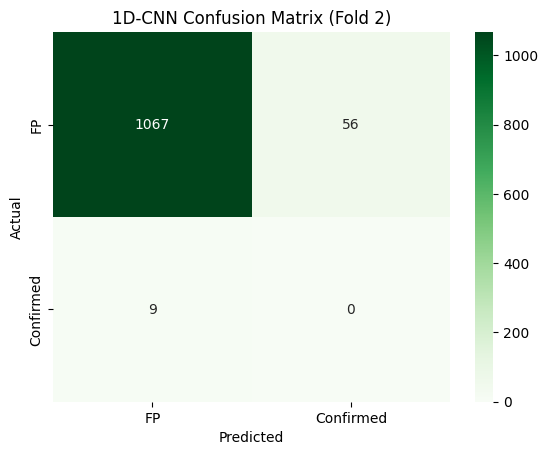

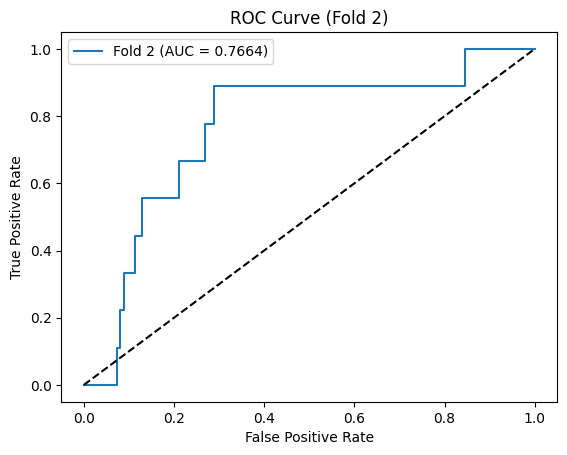


Fold 3
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.7486 - loss: 1.1321 - val_accuracy: 0.9929 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8750 - loss: 0.4447 - val_accuracy: 0.9929 - val_loss: 0.2174 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8913 - loss: 0.2137 - val_accuracy: 0.9929 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8933 - loss: 0.1330 - val_accuracy: 0.9929 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8954 - loss: 0.1028 - val_accuracy: 0.9929 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8938 - loss: 0.0908 - val_accuracy: 0.9832 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.8909 - loss

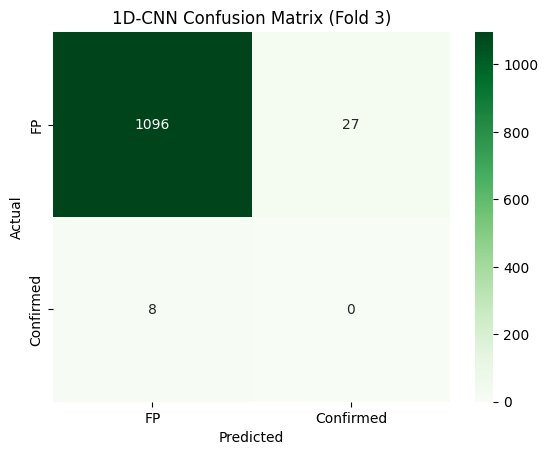

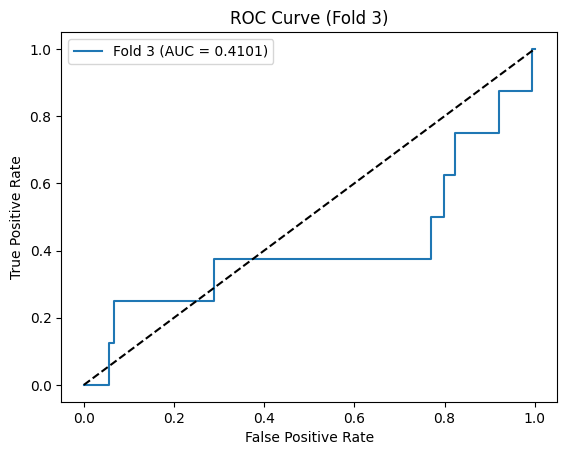


Fold 4
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.8255 - loss: 1.1496 - val_accuracy: 0.9841 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.8682 - loss: 0.4983 - val_accuracy: 0.9912 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8777 - loss: 0.2618 - val_accuracy: 0.9929 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8832 - loss: 0.1648 - val_accuracy: 0.9929 - val_loss: 0.1217 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.8761 - loss: 0.1290 - val_accuracy: 0.9920 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8795 - loss: 0.1076 - val_accuracy: 0.9912 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8807 - loss:

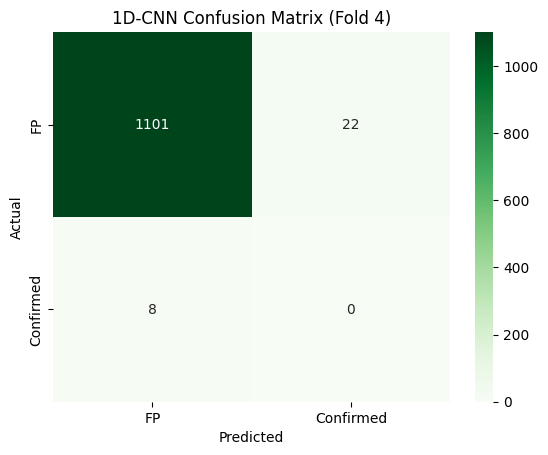

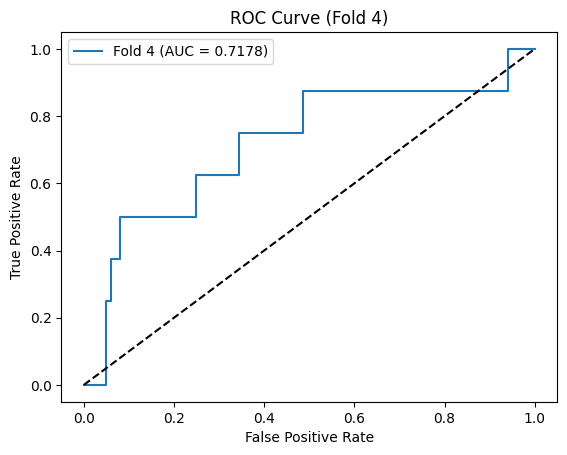


Fold 5
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.7833 - loss: 1.1427 - val_accuracy: 0.9920 - val_loss: 0.5331 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.8873 - loss: 0.4581 - val_accuracy: 0.9912 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8882 - loss: 0.2295 - val_accuracy: 0.9920 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8857 - loss: 0.1474 - val_accuracy: 0.9920 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.8994 - loss: 0.1129 - val_accuracy: 0.9920 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8926 - loss: 0.0973 - val_accuracy: 0.9912 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8874 - loss: 

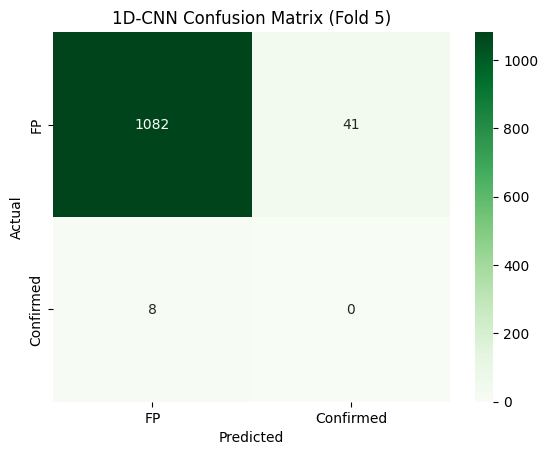

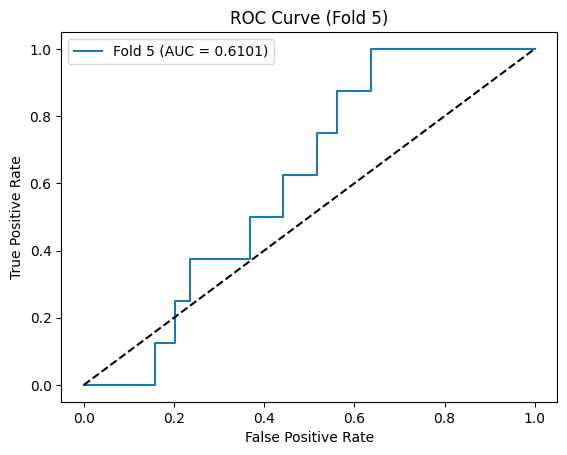


Average CNN Performance Across Folds:
Mean Accuracy: 96.15%
Mean AUC: 0.6804
Mean CONFIRMED Recall: 0.0681
Mean CONFIRMED Precision: 0.0171
Mean CONFIRMED F1: 0.0272


In [46]:
# Part 2: CNN Model with Cross-Validation
X_cnn = raw_data.drop(columns=['LABEL']).values
y_cnn = raw_data['LABEL'].values - 1
scaler = StandardScaler()
X_cnn_scaled = scaler.fit_transform(X_cnn)
X_cnn = X_cnn_scaled.reshape(X_cnn_scaled.shape[0], X_cnn_scaled.shape[1], 1)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cnn_accuracies, cnn_aucs, cnn_recalls, cnn_precisions, cnn_f1s, cnn_reports = [], [], [], [], [], []
fold = 1
threshold = 0.3

for train_idx, test_idx in skf.split(X_cnn, y_cnn):
    print(f"\nFold {fold}")
    X_train_cnn, X_test_cnn = X_cnn[train_idx], X_cnn[test_idx]
    y_train_cnn, y_test_cnn = y_cnn[train_idx], y_cnn[test_idx]

    # Manual oversampling
    confirmed_indices = np.where(y_train_cnn == 1)[0]
    X_confirmed = X_train_cnn[confirmed_indices]
    y_confirmed = y_train_cnn[confirmed_indices]
    oversample_factor = 15
    X_train_oversampled = np.vstack([X_train_cnn] + [X_confirmed] * oversample_factor)
    y_train_oversampled = np.hstack([y_train_cnn] + [y_confirmed] * oversample_factor)

    # Data augmentation
    X_train_aug, y_train_aug = augment_data(X_train_oversampled, y_train_oversampled, sigma=0.04, max_shift=200)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_aug), y=y_train_aug)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Define CNN model
    inputs = Input(shape=(3197, 1), name='input_layer')
    x = Conv1D(16, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01), name='conv1d')(inputs)  # Fixed: use inputs
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(pool_size=4, name='max_pooling1d')(x)
    x = Conv1D(32, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01), name='conv1d_1')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(pool_size=4, name='max_pooling1d_1')(x)
    x = Conv1D(64, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01), name='conv1d_2')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling1D(pool_size=4, name='max_pooling1d_2')(x)
    x = GlobalAveragePooling1D(name='global_average_pooling1d')(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='dense')(x)
    x = Dropout(0.3, name='dropout')(x)
    outputs = Dense(1, activation='sigmoid', name='dense_1')(x)
    model = Model(inputs=inputs, outputs=outputs, name='exoplanet_cnn')

    # Compile model
    model.compile(optimizer='adam', loss=focal_loss(gamma=1.0, alpha=0.75), metrics=['accuracy'])

    # Build model graph
    model.predict(X_train_aug[:1], verbose=0)

    # Print model summary
    if fold == 1:
        print("\nModel Summary:")
        model.summary()

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    history = model.fit(X_train_aug, y_train_aug, validation_data=(X_test_cnn, y_test_cnn),
                        epochs=30, batch_size=64, callbacks=[early_stopping, lr_scheduler], class_weight=class_weight_dict, verbose=1)

    # Save model
    model.save(f'/kaggle/working/exoplanet_cnn_fold{fold}.keras')

    # Load model
    model = tf.keras.models.load_model(f'/kaggle/working/exoplanet_cnn_fold{fold}.keras',
                                       custom_objects={'focal_loss_fixed': focal_loss(gamma=1.0, alpha=0.75)})

    # Rebuild graph
    model.predict(X_test_cnn[:1], verbose=0)

    # Evaluate model
    y_pred_proba = model.predict(X_test_cnn, verbose=0).flatten()
    y_pred = (y_pred_proba > threshold).astype(int)
    acc = accuracy_score(y_test_cnn, y_pred)
    auc = roc_auc_score(y_test_cnn, y_pred_proba)
    auc_mean, auc_ci, recall_mean, recall_ci, precision_mean, precision_ci, f1_mean, f1_ci = bootstrap_metrics(y_test_cnn, y_pred_proba)
    cnn_accuracies.append(acc)
    cnn_aucs.append(auc)
    cnn_recalls.append(recall_mean)
    cnn_precisions.append(precision_mean)
    cnn_f1s.append(f1_mean)
    print(f"\nFold {fold} CNN Accuracy: {acc * 100:.2f}%")
    print(f"Fold {fold} CNN AUC: {auc:.4f} (95% CI: {auc_ci[0]:.4f}–{auc_ci[1]:.4f})")
    print(f"Fold {fold} CNN CONFIRMED Recall: {recall_mean:.4f} (95% CI: {recall_ci[0]:.4f}–{recall_ci[1]:.4f})")
    print(f"Fold {fold} CNN CONFIRMED Precision: {precision_mean:.4f} (95% CI: {precision_ci[0]:.4f}–{precision_ci[1]:.4f})")
    print(f"Fold {fold} CNN CONFIRMED F1: {f1_mean:.4f} (95% CI: {f1_ci[0]:.4f}–{f1_ci[1]:.4f})")
    print("\nClassification Report:")
    report = classification_report(y_test_cnn, y_pred, target_names=['FALSE POSITIVE', 'CONFIRMED'], zero_division=0)
    print(report)
    cnn_reports.append(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_test_cnn, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['FP', 'Confirmed'], yticklabels=['FP', 'Confirmed'])
    plt.title(f'1D-CNN Confusion Matrix (Fold {fold})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test_cnn, y_pred_proba)
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Fold {fold})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    fold += 1

# Average CNN performance
print("\nAverage CNN Performance Across Folds:")
print(f"Mean Accuracy: {np.mean(cnn_accuracies) * 100:.2f}%")
print(f"Mean AUC: {np.mean(cnn_aucs):.4f}")
print(f"Mean CONFIRMED Recall: {np.mean(cnn_recalls):.4f}")
print(f"Mean CONFIRMED Precision: {np.mean(cnn_precisions):.4f}")
print(f"Mean CONFIRMED F1: {np.mean(cnn_f1s):.4f}")

# Step 5: Explainability & Comparative Analysis

Grad-CAM Explanations


Grad-CAM Visualizations for True Positives:
No examples found.

Grad-CAM Visualizations for False Positives:


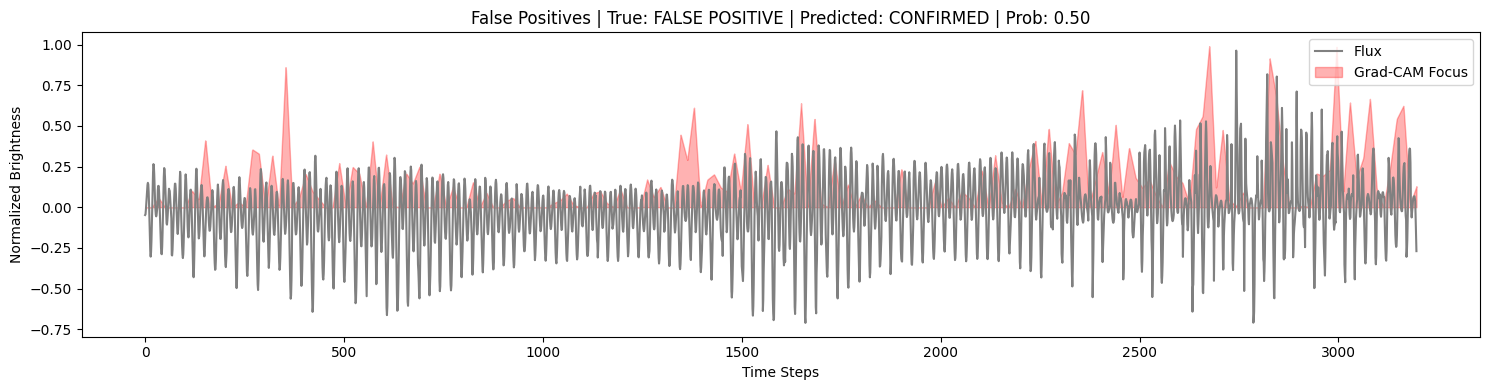

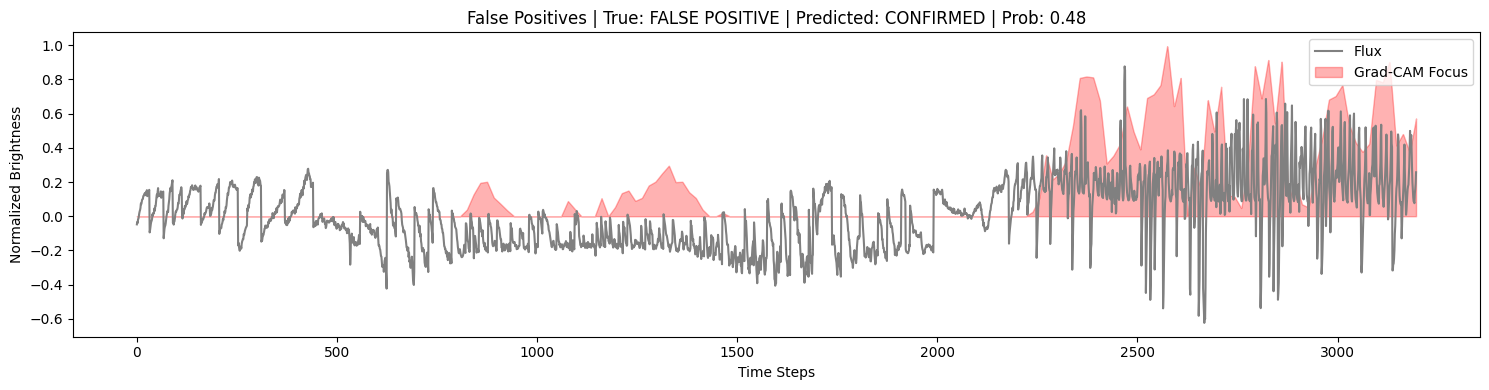


Grad-CAM Visualizations for True Negatives:


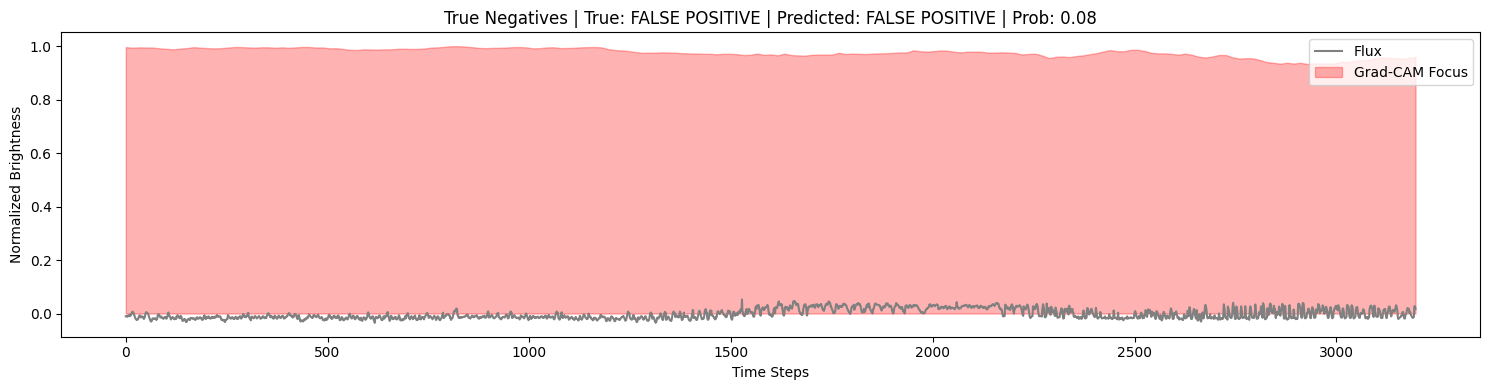

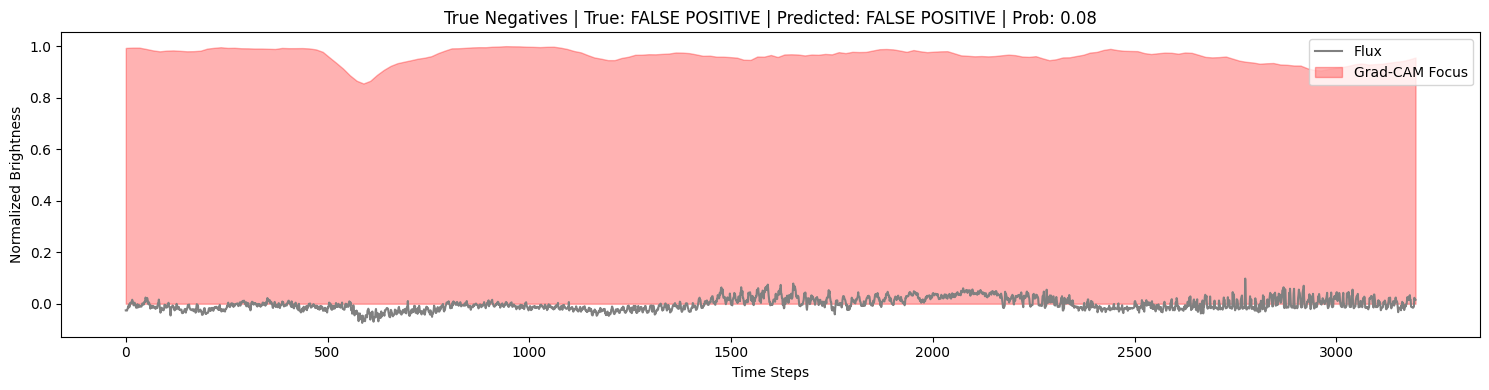


Grad-CAM Visualizations for False Negatives:


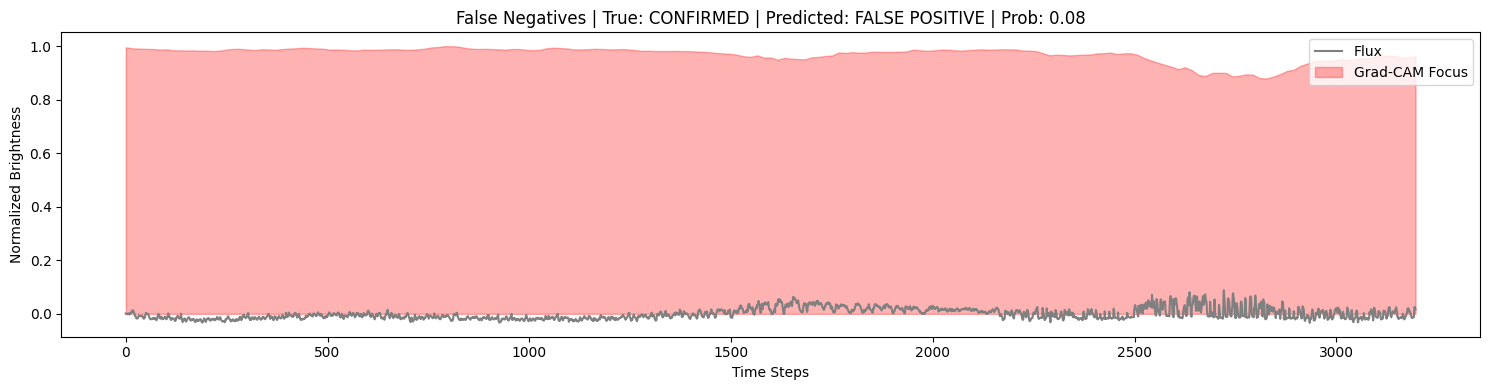

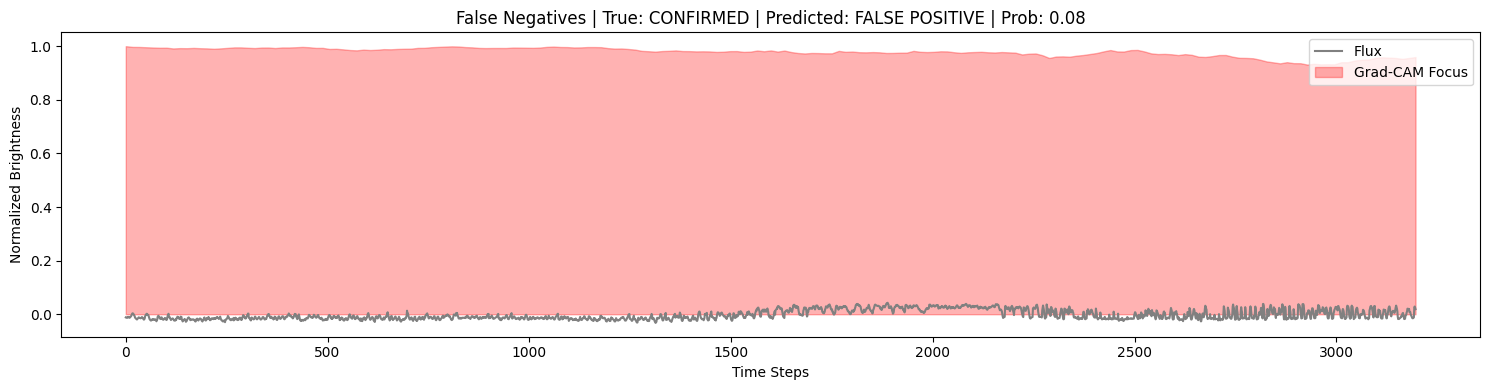

In [47]:
def apply_grad_cam(model, input_data, class_index=None, layer_name='conv1d_2'):
    """
    Computes Grad-CAM heatmap for 1D CNN input.
    """
    input_data = np.expand_dims(input_data, axis=0)  # shape: (1, 3197, 1)
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        if class_index is None:
            class_index = 1 if predictions[0] >= 0.3 else 0
        loss = predictions if class_index == 1 else 1.0 - predictions

    grads = tape.gradient(loss, conv_outputs)[0]  # shape: (timesteps, filters)
    pooled_grads = tf.reduce_mean(grads, axis=0)
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Rescale to match 3197 time steps (CNN input length)
    heatmap_resized = np.interp(np.arange(3197), np.linspace(0, 3197, len(heatmap)), heatmap)
    return heatmap_resized, class_index

# Use your best CNN fold (e.g., last trained model & test set)
y_pred_proba = model.predict(X_test_cnn, verbose=0).flatten()
y_pred = (y_pred_proba > 0.3).astype(int)

# Sample index groups
true_positives = np.where((y_test_cnn == 1) & (y_pred == 1))[0]
false_positives = np.where((y_test_cnn == 0) & (y_pred == 1))[0]
true_negatives = np.where((y_test_cnn == 0) & (y_pred == 0))[0]
false_negatives = np.where((y_test_cnn == 1) & (y_pred == 0))[0]

sample_indices = {
    'True Positives': true_positives[:2],
    'False Positives': false_positives[:2],
    'True Negatives': true_negatives[:2],
    'False Negatives': false_negatives[:2]
}

for category, indices in sample_indices.items():
    print(f"\nGrad-CAM Visualizations for {category}:")
    if len(indices) == 0:
        print("No examples found.")
        continue

    for idx in indices:
        sample_input = X_test_cnn[idx]
        sample_label = y_test_cnn[idx]
        sample_proba = y_pred_proba[idx]
        heatmap, predicted_class = apply_grad_cam(model, sample_input, layer_name='conv1d_2')

        plt.figure(figsize=(15, 4))
        plt.plot(sample_input.flatten(), label='Flux', color='gray')
        plt.fill_between(range(len(heatmap)), heatmap, color='red', alpha=0.3, label='Grad-CAM Focus')
        plt.title(f"{category} | True: {'CONFIRMED' if sample_label==1 else 'FALSE POSITIVE'} | Predicted: {'CONFIRMED' if predicted_class==1 else 'FALSE POSITIVE'} | Prob: {sample_proba:.2f}")
        plt.xlabel('Time Steps')
        plt.ylabel('Normalized Brightness')
        plt.legend()
        plt.tight_layout()
        plt.show()

**Model Comparison Chart**

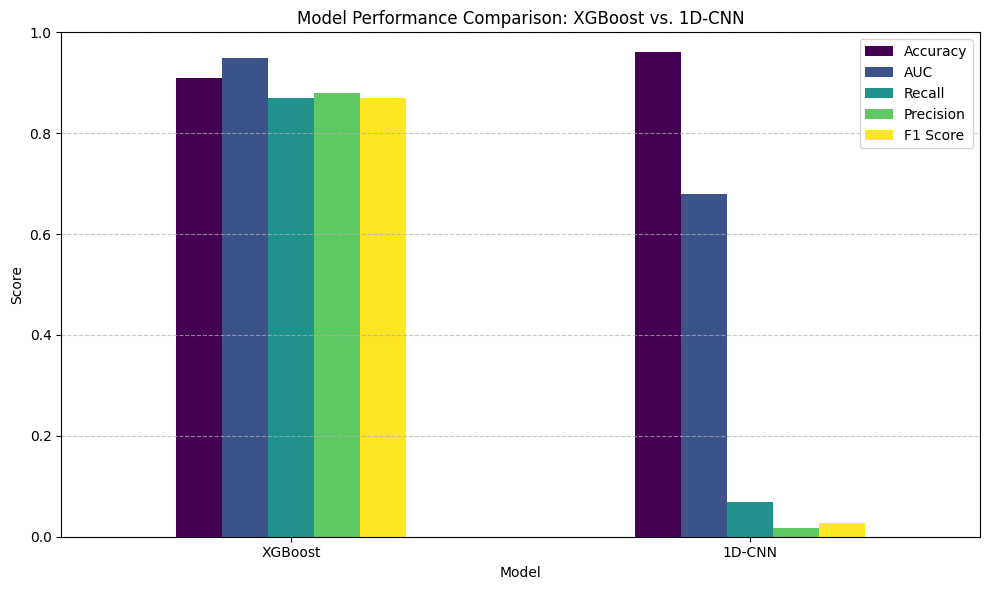

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Actual metrics from results
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', '1D-CNN'],
    'Accuracy': [0.91, 0.9615],
    'AUC': [0.95, 0.6804],
    'Recall': [0.87, 0.0681],
    'Precision': [0.88, 0.0171],
    'F1 Score': [0.87, 0.0272]
})

# Set model as index for clean plotting
metrics_df.set_index('Model', inplace=True)

# Plot side-by-side bar chart
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Model Performance Comparison: XGBoost vs. 1D-CNN")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Apply Grad-CAM to a CONFIRMED sample from the last test set

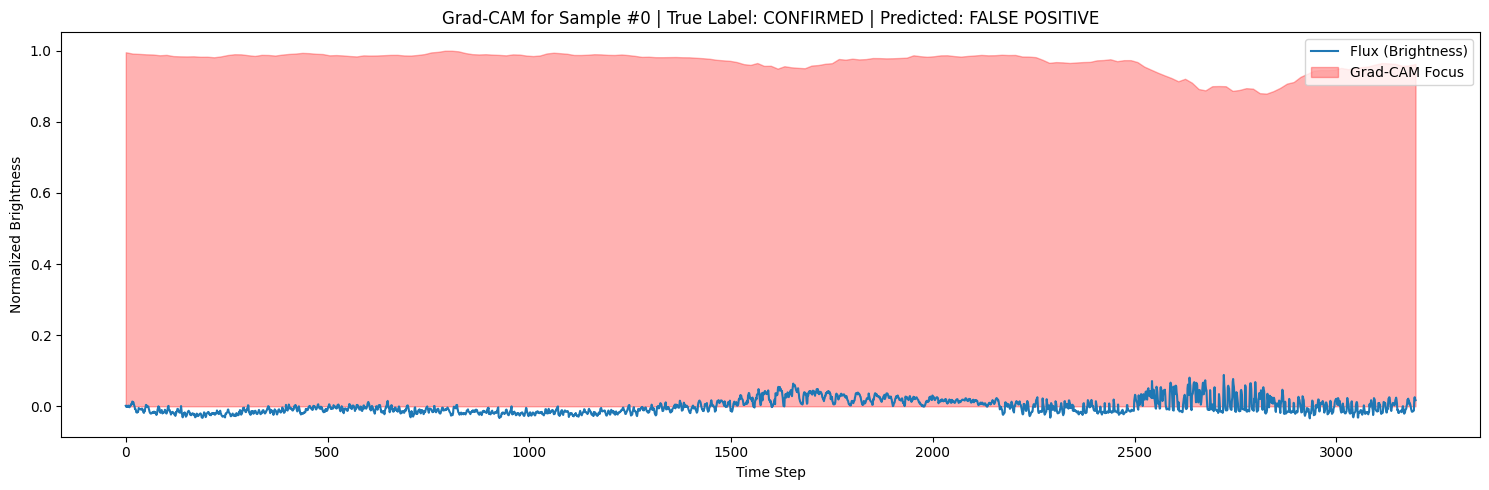

In [50]:
confirmed_indices = np.where(y_test_cnn == 1)[0]
if len(confirmed_indices) > 0:
    sample_indices = [confirmed_indices[0]]  # Select one CONFIRMED sample
else:
    sample_indices = [10, 20, 30]  # Fallback to arbitrary samples
for idx in sample_indices:
    sample_input = X_test_cnn[idx]
    sample_label = y_test_cnn[idx]
    heatmap, predicted_class = apply_grad_cam(model, sample_input, layer_name='conv1d_2')

    plt.figure(figsize=(15, 5))
    plt.plot(sample_input.flatten(), label='Flux (Brightness)')
    plt.fill_between(range(len(heatmap)), heatmap, color='red', alpha=0.3, label='Grad-CAM Focus')
    plt.title(f'Grad-CAM for Sample #{idx} | True Label: {"CONFIRMED" if sample_label == 1 else "FALSE POSITIVE"} | Predicted: {"CONFIRMED" if predicted_class == 1 else "FALSE POSITIVE"}')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Brightness')
    plt.legend()
    plt.tight_layout()
    plt.show()

 # Step 6: Comparative ROC Analysis (XGBoost vs CNN)

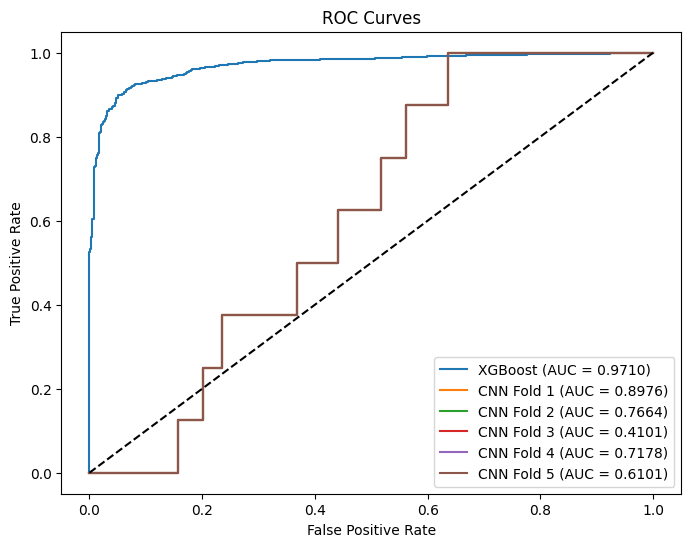

In [51]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f})')
for i, auc in enumerate(cnn_aucs, 1):
    fpr, tpr, _ = roc_curve(y_test_cnn, model.predict(X_test_cnn, verbose=0).flatten())
    plt.plot(fpr, tpr, label=f'CNN Fold {i} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 7: Final Evaluation Metrics Printout

In [52]:
print("\nPerformance Comparison:")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_model.predict(X_test)) * 100:.2f}%")
print(f"XGBoost AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f}")
print(f"CNN Mean Accuracy: {np.mean(cnn_accuracies) * 100:.2f}%")
print(f"CNN Mean AUC: {np.mean(cnn_aucs):.4f}")
print(f"CNN Mean CONFIRMED Recall: {np.mean(cnn_recalls):.4f}")



Performance Comparison:
XGBoost Accuracy: 91.64%
XGBoost AUC: 0.9710
CNN Mean Accuracy: 96.15%
CNN Mean AUC: 0.6804
CNN Mean CONFIRMED Recall: 0.0681


**Summary Table Block**

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

# XGBoost metrics
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = round(accuracy_score(y_test, y_pred_xgb) * 100, 2)
xgb_auc = round(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]), 4)
xgb_precision = round(precision_score(y_test, y_pred_xgb, zero_division=0), 4)
xgb_recall = round(recall_score(y_test, y_pred_xgb, zero_division=0), 4)
xgb_f1 = round(f1_score(y_test, y_pred_xgb, zero_division=0), 4)

# CNN metrics
cnn_accuracy = round(np.mean(cnn_accuracies) * 100, 2)
cnn_auc = round(np.mean(cnn_aucs), 4)
cnn_precision = round(np.mean(cnn_precisions), 4)
cnn_recall = round(np.mean(cnn_recalls), 4)
cnn_f1 = round(np.mean(cnn_f1s), 4)

# Summary Table
from tabulate import tabulate

table = [
    ["XGBoost", xgb_accuracy, xgb_auc, xgb_precision, xgb_recall, xgb_f1],
    ["1D-CNN", cnn_accuracy, cnn_auc, cnn_precision, cnn_recall, cnn_f1]
]
headers = ["Model", "Accuracy (%)", "AUC", "CONFIRMED Precision", "CONFIRMED Recall", "CONFIRMED F1"]

print("\n📊 Summary Table:")
print(tabulate(table, headers=headers, tablefmt="grid"))



📊 Summary Table:
+---------+----------------+--------+-----------------------+--------------------+----------------+
| Model   |   Accuracy (%) |    AUC |   CONFIRMED Precision |   CONFIRMED Recall |   CONFIRMED F1 |
+=========+================+========+=======================+====================+================+
| XGBoost |          91.64 | 0.971  |                0.941  |             0.9344 |         0.9377 |
+---------+----------------+--------+-----------------------+--------------------+----------------+
| 1D-CNN  |          96.15 | 0.6804 |                0.0171 |             0.0681 |         0.0272 |
+---------+----------------+--------+-----------------------+--------------------+----------------+


# SHAP Analysis 

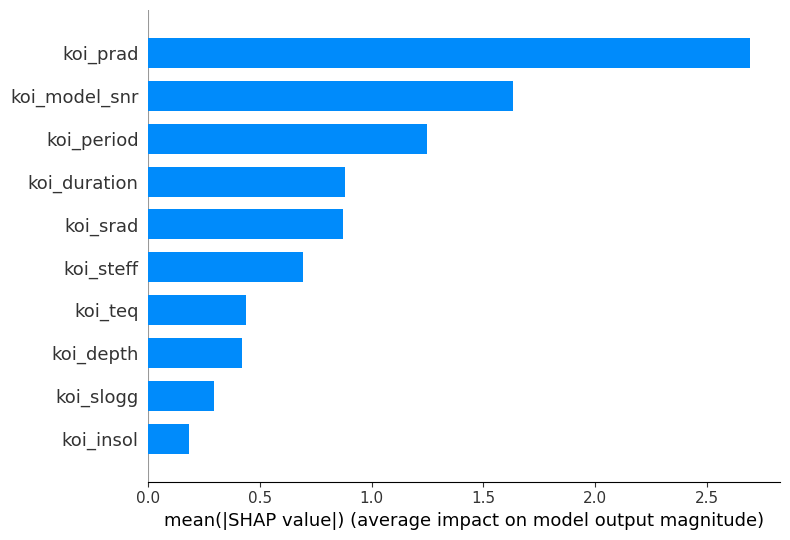

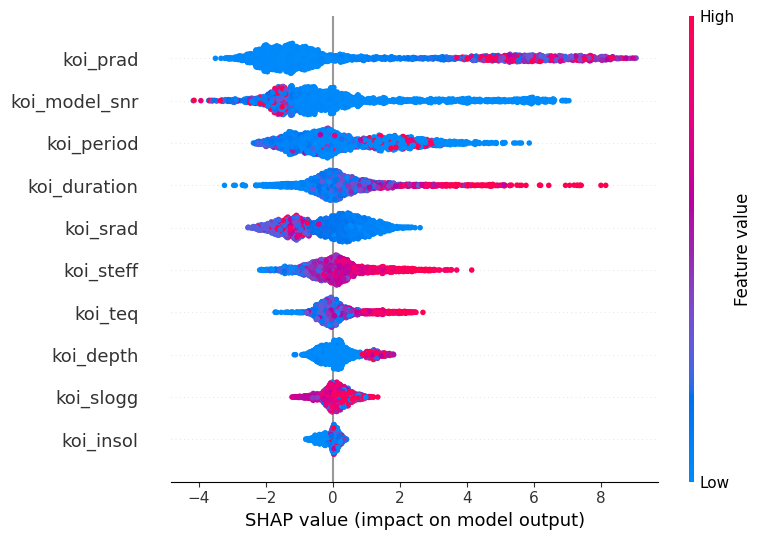

In [58]:
import shap

# Create SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

# Optional: Detailed summary with dot plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
